In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

#from torchsummary import summary
#import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import numpy as np
from PIL import Image

In [ ]:

import torch
import torch.nn as nn

import torch
import torch.nn as nn
def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels, affine=False, track_running_stats=False),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels, affine=False, track_running_stats=False),
        nn.ReLU(inplace=True)
    )
    return conv_op




class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=3,
            kernel_size=1
        )

    def forward(self, x):
        # TODO: Write here!
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        up_1 = self.up_transpose_1(down_9)
        up_2 = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_3 = self.up_transpose_2(up_2)
        up_4 = self.up_convolution_2(torch.cat([down_5, up_3], 1))
        up_5 = self.up_transpose_3(up_4)
        up_6 = self.up_convolution_3(torch.cat([down_3, up_5], 1))
        up_7 = self.up_transpose_4(up_6)
        up_8 = self.up_convolution_4(torch.cat([down_1, up_7], 1))

        out = self.out(up_8)

        return out

In [ ]:
import os
from glob import glob
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_msk=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_img = transform_img
        self.transform_msk = transform_msk
        # Define the transformations to be applied to the images and masks


        self.transform_img = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0,0,0], std=[1,1,1])

])

        self.transform_msk = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0,0,0], std=[1,1,1])

])

        self.image_paths = sorted(glob(os.path.join(self.image_dir, '*.png')))
        self.mask_paths = sorted(glob(os.path.join(self.mask_dir, '*.png')))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            raise FileNotFoundError(f"Image or mask file not found at index {idx}")

        image = Image.open(img_path).convert("RGB")
        image = self.transform_img(image)

        mask = (Image.open(mask_path))
        mask = self.transform_msk(mask)



        return image, mask


In [ ]:
# Define the paths to the training and testing data
train_image_dir = "/kaggle/input/new-dataset-covid19/images_train/images_train/"
train_mask_dir = "/kaggle/input/new-dataset-covid19/annotations_train/annotations_train/"

val_image_dir = "/kaggle/input/new-dataset-covid19/images_val/images_val/"
val_mask_dir = "/kaggle/input/new-dataset-covid19/annotations_val/annotations_val/"

test_image_dir = "/kaggle/input/new-dataset-covid19/images_test/images_test/"
test_mask_dir = "/kaggle/input/new-dataset-covid19/annotations_test/annotations_test/"



# Define the training and testing datasets
train_dataset = CustomDataset(train_image_dir, train_mask_dir)
test_dataset = CustomDataset(test_image_dir, test_mask_dir)
val_dataset = CustomDataset(val_image_dir, val_mask_dir)

# Define the training and testing data loaders
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)

# Define the device to be used for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = UNet().to(device)

In [ ]:
import torch.optim as optim
epochs=500
# Setup loss function and optimizer
criterion = nn.BCEWithLogitsLoss()# DiceLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)

In [ ]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1 of 300
Train loss: 1.27786, Dice: 0.96058, BCE: 0.31728 | Test loss: 1.15260, Dice: 0.95314, BCE: 0.19946



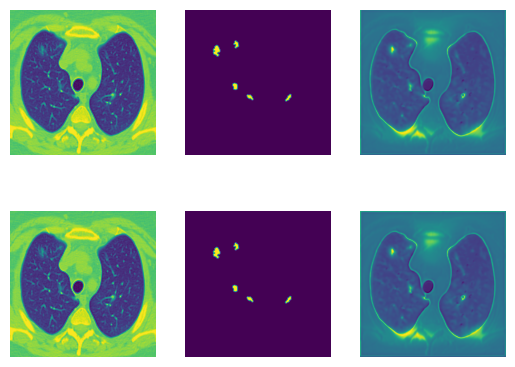

Epoch: 2 of 300
Train loss: 0.93060, Dice: 0.82681, BCE: 0.10379 | Test loss: 1.00732, Dice: 0.89287, BCE: 0.11445

Epoch: 3 of 300
Train loss: 0.62405, Dice: 0.57000, BCE: 0.05405 | Test loss: 0.77354, Dice: 0.68182, BCE: 0.09172

Epoch: 4 of 300
Train loss: 0.51416, Dice: 0.46558, BCE: 0.04858 | Test loss: 0.69014, Dice: 0.60834, BCE: 0.08180

Epoch: 5 of 300
Train loss: 0.42392, Dice: 0.38073, BCE: 0.04318 | Test loss: 0.61321, Dice: 0.53458, BCE: 0.07863

Epoch: 6 of 300
Train loss: 0.38687, Dice: 0.34675, BCE: 0.04012 | Test loss: 0.54640, Dice: 0.47879, BCE: 0.06761



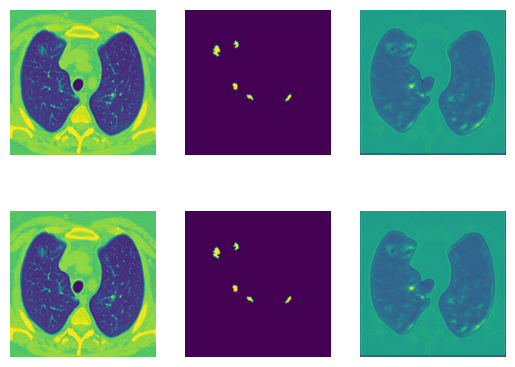

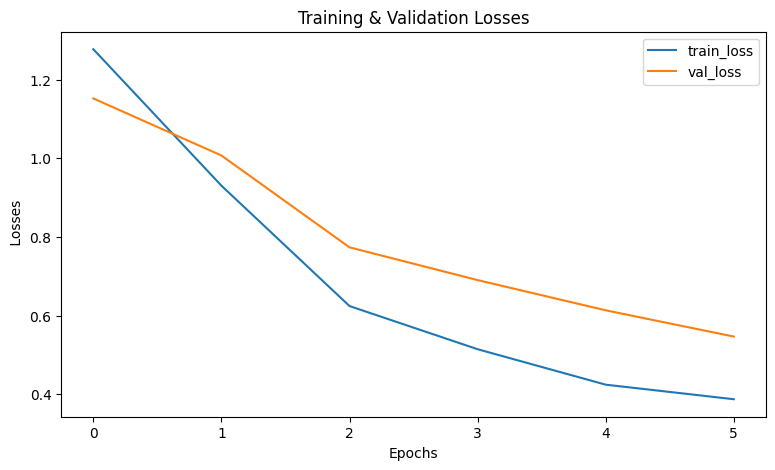

Epoch: 7 of 300
Train loss: 0.35105, Dice: 0.31393, BCE: 0.03712 | Test loss: 0.51752, Dice: 0.45194, BCE: 0.06558

Epoch: 8 of 300
Train loss: 0.34609, Dice: 0.30822, BCE: 0.03788 | Test loss: 0.49252, Dice: 0.42552, BCE: 0.06700

Epoch: 9 of 300
Train loss: 0.32979, Dice: 0.29377, BCE: 0.03602 | Test loss: 0.46975, Dice: 0.40879, BCE: 0.06095

Epoch: 10 of 300
Train loss: 0.30968, Dice: 0.27562, BCE: 0.03405 | Test loss: 0.49588, Dice: 0.42817, BCE: 0.06771

Epoch: 11 of 300
Train loss: 0.29309, Dice: 0.26089, BCE: 0.03220 | Test loss: 0.45574, Dice: 0.39848, BCE: 0.05727



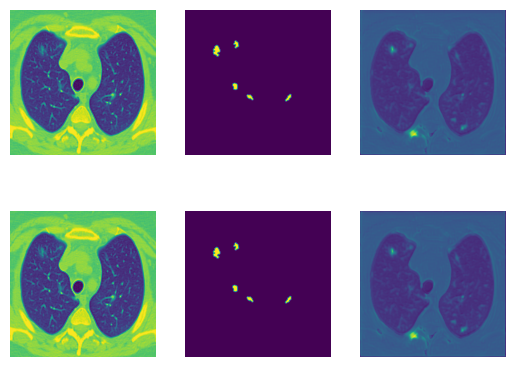

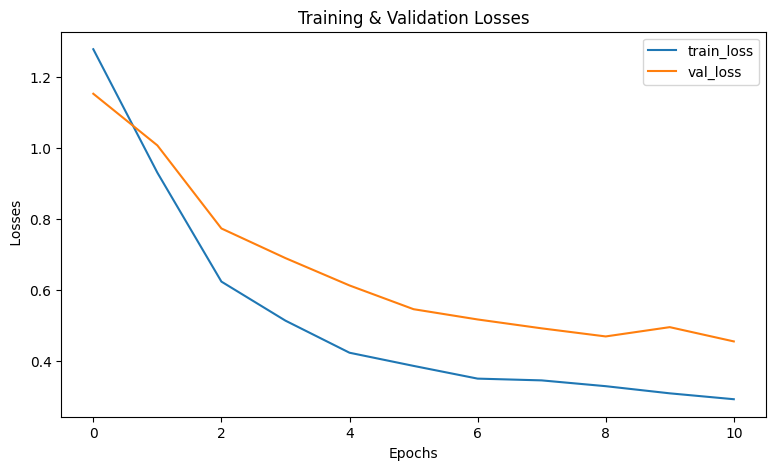

Epoch: 12 of 300
Train loss: 0.28177, Dice: 0.25089, BCE: 0.03088 | Test loss: 0.42535, Dice: 0.36576, BCE: 0.05959

Epoch: 13 of 300
Train loss: 0.26657, Dice: 0.23707, BCE: 0.02950 | Test loss: 0.43333, Dice: 0.37192, BCE: 0.06141

Epoch: 14 of 300
Train loss: 0.26941, Dice: 0.23926, BCE: 0.03015 | Test loss: 0.43404, Dice: 0.37180, BCE: 0.06223

Epoch: 15 of 300
Train loss: 0.25677, Dice: 0.22800, BCE: 0.02878 | Test loss: 0.41008, Dice: 0.35120, BCE: 0.05888

Epoch: 16 of 300
Train loss: 0.24935, Dice: 0.22159, BCE: 0.02776 | Test loss: 0.42990, Dice: 0.37189, BCE: 0.05801



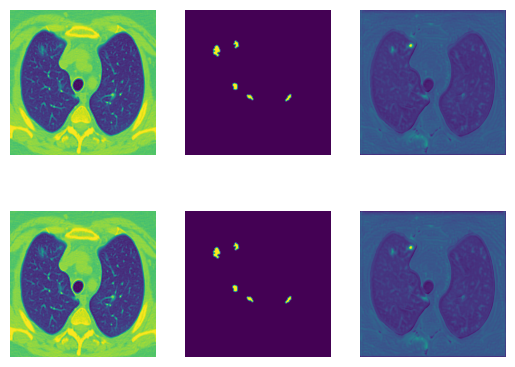

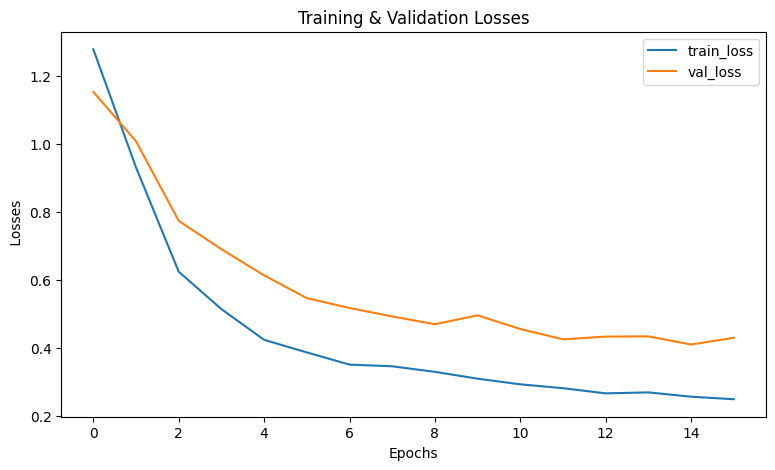

Epoch: 17 of 300
Train loss: 0.24320, Dice: 0.21588, BCE: 0.02731 | Test loss: 0.40495, Dice: 0.34592, BCE: 0.05902

Epoch: 18 of 300
Train loss: 0.24437, Dice: 0.21671, BCE: 0.02765 | Test loss: 0.41393, Dice: 0.35641, BCE: 0.05752

Epoch: 19 of 300
Train loss: 0.22508, Dice: 0.19977, BCE: 0.02532 | Test loss: 0.41228, Dice: 0.35570, BCE: 0.05658

Epoch: 20 of 300
Train loss: 0.22133, Dice: 0.19664, BCE: 0.02469 | Test loss: 0.40354, Dice: 0.34833, BCE: 0.05521

Epoch: 21 of 300
Train loss: 0.21689, Dice: 0.19302, BCE: 0.02387 | Test loss: 0.38425, Dice: 0.32529, BCE: 0.05897



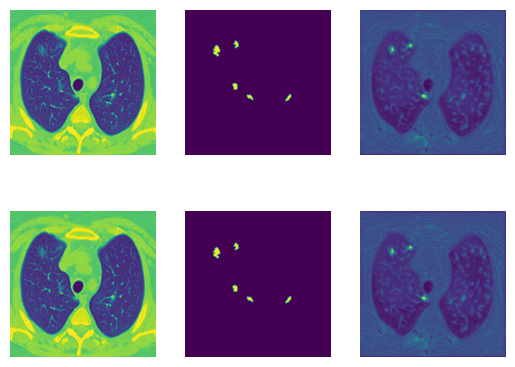

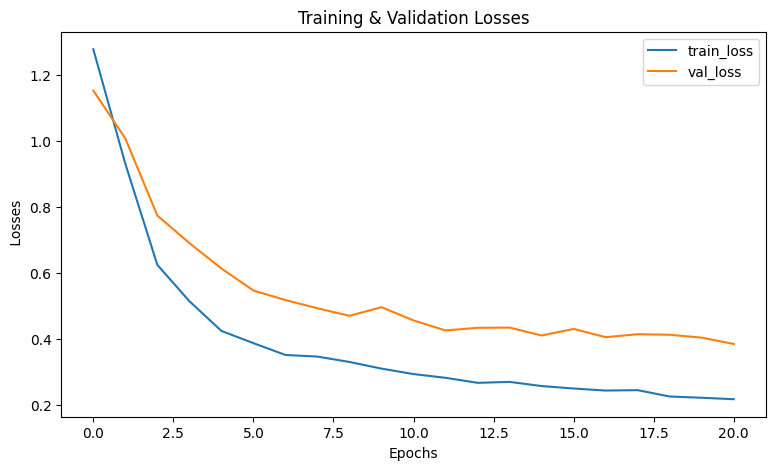

Epoch: 22 of 300
Train loss: 0.21596, Dice: 0.19203, BCE: 0.02393 | Test loss: 0.38166, Dice: 0.32443, BCE: 0.05723

Epoch: 23 of 300
Train loss: 0.21802, Dice: 0.19337, BCE: 0.02465 | Test loss: 0.36863, Dice: 0.31316, BCE: 0.05546

Epoch: 24 of 300
Train loss: 0.21036, Dice: 0.18667, BCE: 0.02369 | Test loss: 0.38228, Dice: 0.32838, BCE: 0.05390

Epoch: 25 of 300
Train loss: 0.21353, Dice: 0.18970, BCE: 0.02383 | Test loss: 0.36654, Dice: 0.31068, BCE: 0.05586

Epoch: 26 of 300
Train loss: 0.20477, Dice: 0.18189, BCE: 0.02287 | Test loss: 0.35791, Dice: 0.30182, BCE: 0.05609

Epoch: 28 of 300
Train loss: 0.19790, Dice: 0.17565, BCE: 0.02225 | Test loss: 0.36109, Dice: 0.30745, BCE: 0.05364

Epoch: 29 of 300
Train loss: 0.19662, Dice: 0.17463, BCE: 0.02199 | Test loss: 0.36919, Dice: 0.31992, BCE: 0.04927

Epoch: 30 of 300
Train loss: 0.18474, Dice: 0.16435, BCE: 0.02039 | Test loss: 0.34827, Dice: 0.29509, BCE: 0.05318

Epoch: 33 of 300
Train loss: 0.18236, Dice: 0.16205, BCE: 0.0203

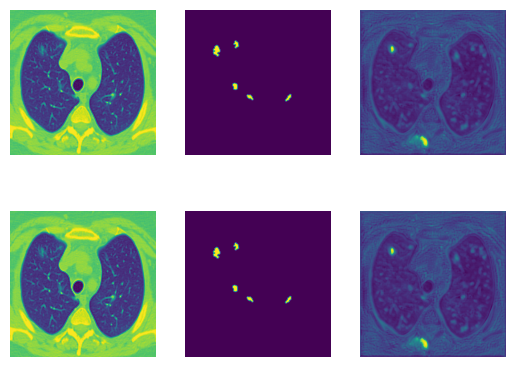

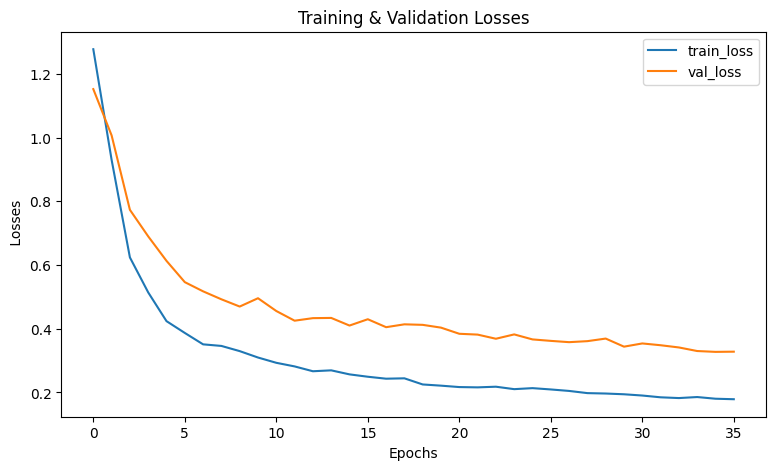

Epoch: 37 of 300
Train loss: 0.17351, Dice: 0.15439, BCE: 0.01912 | Test loss: 0.34322, Dice: 0.28502, BCE: 0.05820

Epoch: 38 of 300
Train loss: 0.17686, Dice: 0.15725, BCE: 0.01961 | Test loss: 0.32101, Dice: 0.27169, BCE: 0.04932

Epoch: 39 of 300
Train loss: 0.17095, Dice: 0.15202, BCE: 0.01893 | Test loss: 0.32443, Dice: 0.27375, BCE: 0.05068

Epoch: 40 of 300
Train loss: 0.17594, Dice: 0.15646, BCE: 0.01948 | Test loss: 0.36387, Dice: 0.31467, BCE: 0.04920

Epoch: 41 of 300
Train loss: 0.16380, Dice: 0.14567, BCE: 0.01814 | Test loss: 0.31884, Dice: 0.26751, BCE: 0.05133



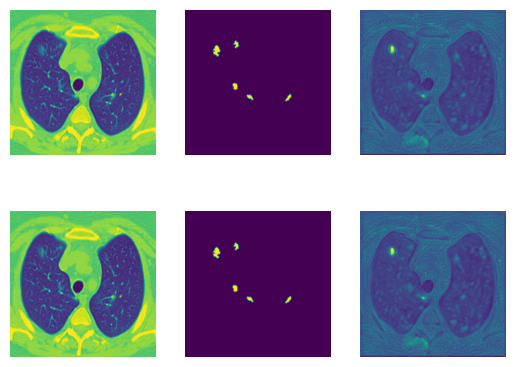

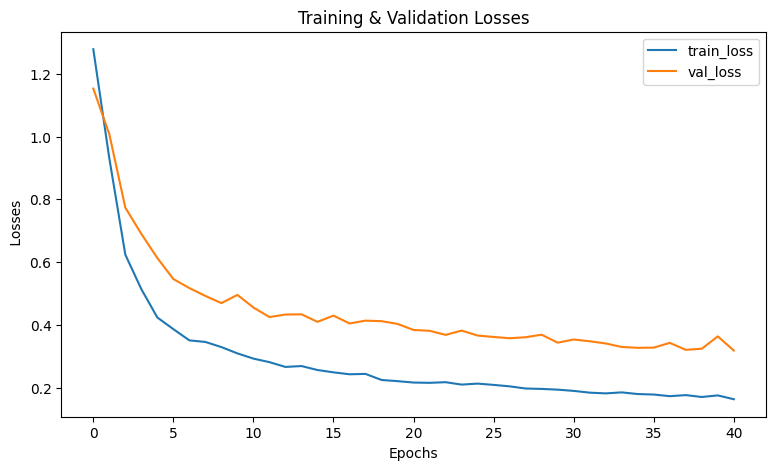

Epoch: 42 of 300
Train loss: 0.15592, Dice: 0.13881, BCE: 0.01711 | Test loss: 0.31857, Dice: 0.26788, BCE: 0.05069

Epoch: 43 of 300
Train loss: 0.17038, Dice: 0.15152, BCE: 0.01885 | Test loss: 0.33044, Dice: 0.28122, BCE: 0.04922

Epoch: 44 of 300
Train loss: 0.15721, Dice: 0.13970, BCE: 0.01751 | Test loss: 0.32734, Dice: 0.27654, BCE: 0.05081

Epoch: 45 of 300
Train loss: 0.15616, Dice: 0.13908, BCE: 0.01708 | Test loss: 0.32846, Dice: 0.27363, BCE: 0.05482

Epoch: 46 of 300
Train loss: 0.15574, Dice: 0.13835, BCE: 0.01739 | Test loss: 0.31251, Dice: 0.26421, BCE: 0.04830



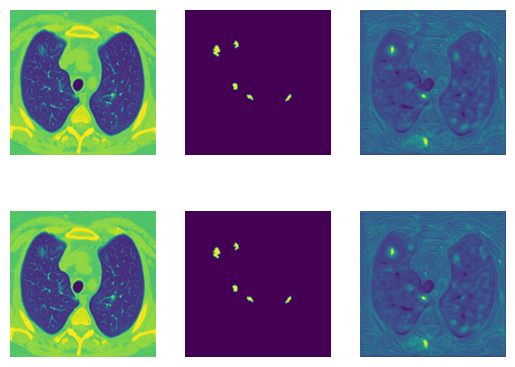

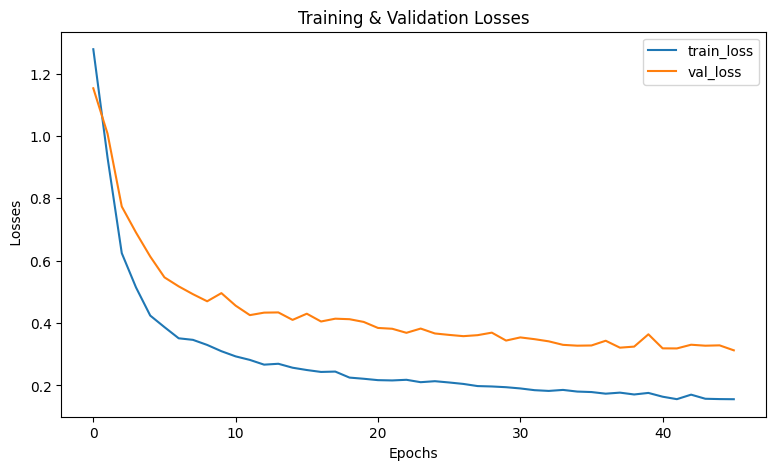

Epoch: 47 of 300
Train loss: 0.15780, Dice: 0.14072, BCE: 0.01708 | Test loss: 0.31274, Dice: 0.26709, BCE: 0.04564

Epoch: 48 of 300
Train loss: 0.15023, Dice: 0.13387, BCE: 0.01637 | Test loss: 0.29916, Dice: 0.25202, BCE: 0.04714

Epoch: 49 of 300
Train loss: 0.14772, Dice: 0.13174, BCE: 0.01598 | Test loss: 0.32280, Dice: 0.26661, BCE: 0.05619

Epoch: 50 of 300
Train loss: 0.15072, Dice: 0.13410, BCE: 0.01661 | Test loss: 0.31193, Dice: 0.26359, BCE: 0.04835

Epoch: 51 of 300
Train loss: 0.14382, Dice: 0.12814, BCE: 0.01568 | Test loss: 0.32191, Dice: 0.27171, BCE: 0.05020



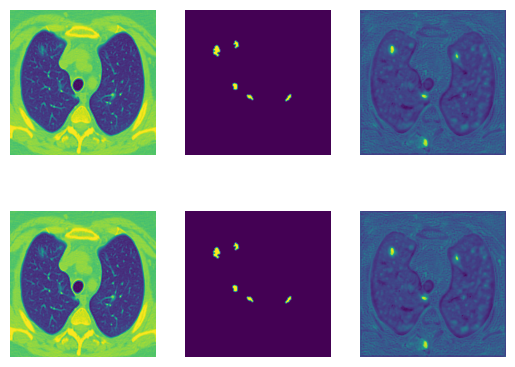

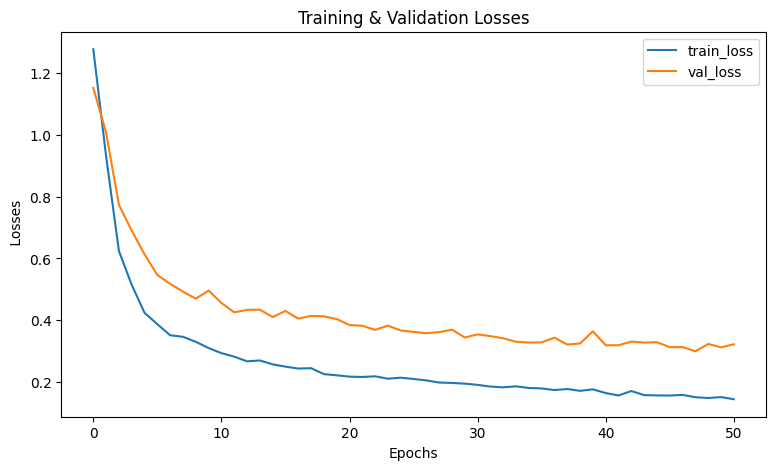

Epoch: 52 of 300
Train loss: 0.14369, Dice: 0.12800, BCE: 0.01570 | Test loss: 0.31106, Dice: 0.26037, BCE: 0.05069

Epoch: 53 of 300
Train loss: 0.15562, Dice: 0.13849, BCE: 0.01714 | Test loss: 0.32599, Dice: 0.27691, BCE: 0.04907

Epoch: 54 of 300
Train loss: 0.14546, Dice: 0.12977, BCE: 0.01570 | Test loss: 0.31066, Dice: 0.26409, BCE: 0.04657

Epoch: 55 of 300
Train loss: 0.13585, Dice: 0.12103, BCE: 0.01482 | Test loss: 0.30170, Dice: 0.25086, BCE: 0.05084

Epoch: 56 of 300
Train loss: 0.14070, Dice: 0.12553, BCE: 0.01518 | Test loss: 0.29598, Dice: 0.24571, BCE: 0.05026



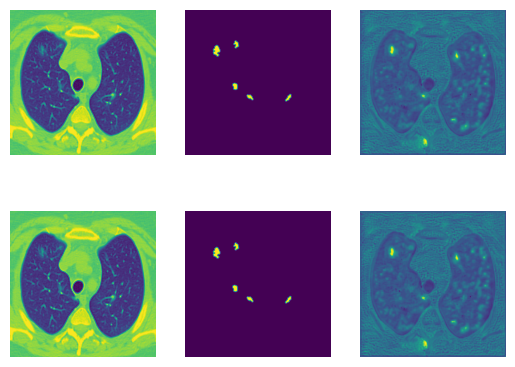

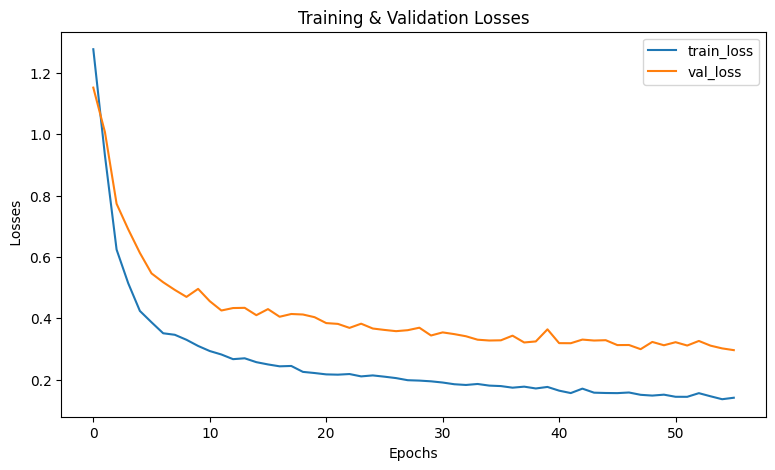

Epoch: 57 of 300
Train loss: 0.14318, Dice: 0.12763, BCE: 0.01556 | Test loss: 0.30682, Dice: 0.25829, BCE: 0.04853

Epoch: 58 of 300
Train loss: 0.13386, Dice: 0.11929, BCE: 0.01457 | Test loss: 0.30687, Dice: 0.25987, BCE: 0.04700

Epoch: 59 of 300
Train loss: 0.13404, Dice: 0.11971, BCE: 0.01433 | Test loss: 0.29187, Dice: 0.24030, BCE: 0.05157

Epoch: 60 of 300
Train loss: 0.13467, Dice: 0.11999, BCE: 0.01468 | Test loss: 0.29793, Dice: 0.24780, BCE: 0.05013

Epoch: 61 of 300
Train loss: 0.12891, Dice: 0.11501, BCE: 0.01390 | Test loss: 0.29835, Dice: 0.24828, BCE: 0.05007



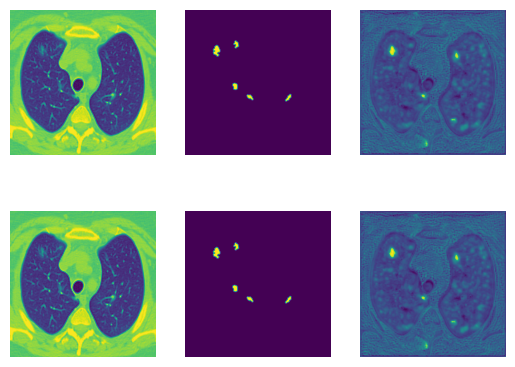

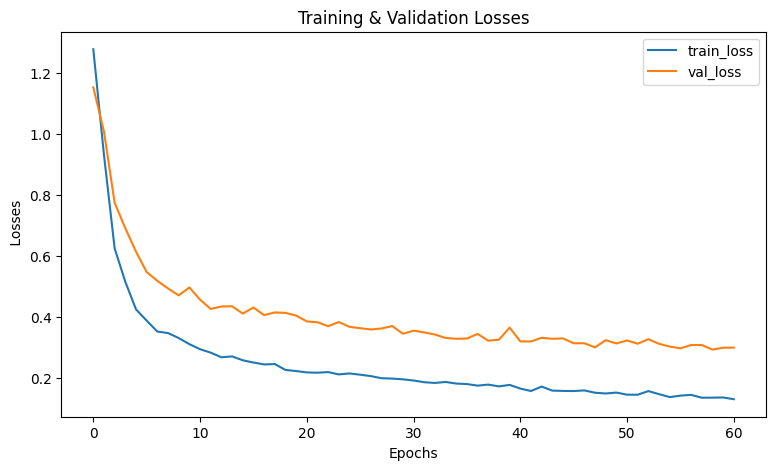

Epoch: 62 of 300
Train loss: 0.13096, Dice: 0.11678, BCE: 0.01418 | Test loss: 0.29511, Dice: 0.24579, BCE: 0.04932

Epoch: 63 of 300
Train loss: 0.13377, Dice: 0.11936, BCE: 0.01442 | Test loss: 0.29764, Dice: 0.24739, BCE: 0.05025

Epoch: 64 of 300
Train loss: 0.13378, Dice: 0.11930, BCE: 0.01448 | Test loss: 0.30560, Dice: 0.25796, BCE: 0.04764

Epoch: 65 of 300
Train loss: 0.12851, Dice: 0.11469, BCE: 0.01381 | Test loss: 0.30628, Dice: 0.25905, BCE: 0.04723

Epoch: 66 of 300
Train loss: 0.14029, Dice: 0.12478, BCE: 0.01550 | Test loss: 0.30678, Dice: 0.25423, BCE: 0.05254



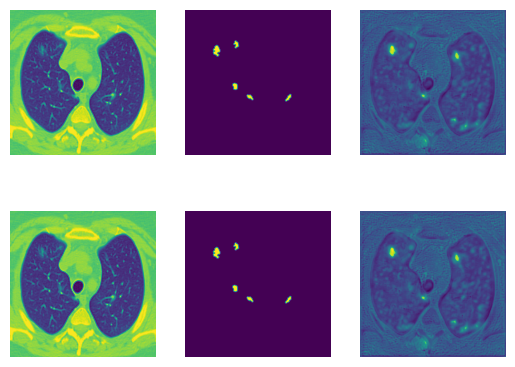

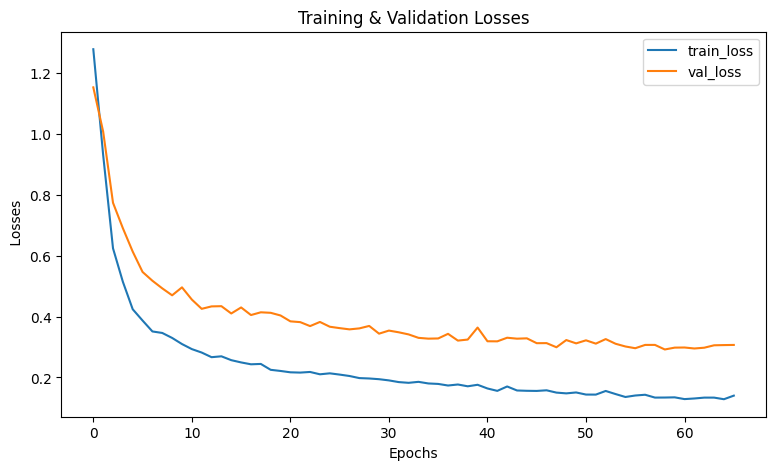

Epoch: 67 of 300
Train loss: 0.12645, Dice: 0.11280, BCE: 0.01365 | Test loss: 0.28284, Dice: 0.23554, BCE: 0.04731

Epoch: 68 of 300
Train loss: 0.12285, Dice: 0.10981, BCE: 0.01304 | Test loss: 0.30811, Dice: 0.25126, BCE: 0.05684

Epoch: 69 of 300
Train loss: 0.14098, Dice: 0.12542, BCE: 0.01556 | Test loss: 0.29829, Dice: 0.24466, BCE: 0.05362

Epoch: 70 of 300
Train loss: 0.13038, Dice: 0.11638, BCE: 0.01399 | Test loss: 0.30496, Dice: 0.25198, BCE: 0.05298

Epoch: 71 of 300
Train loss: 0.12102, Dice: 0.10792, BCE: 0.01310 | Test loss: 0.28712, Dice: 0.23607, BCE: 0.05105



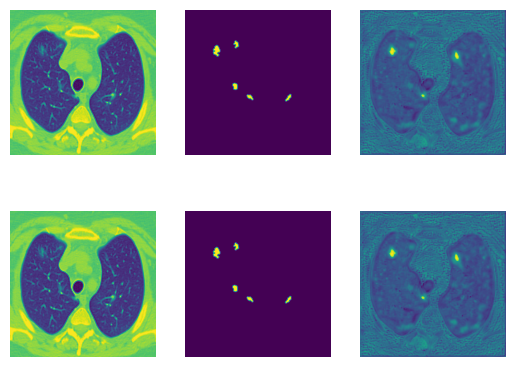

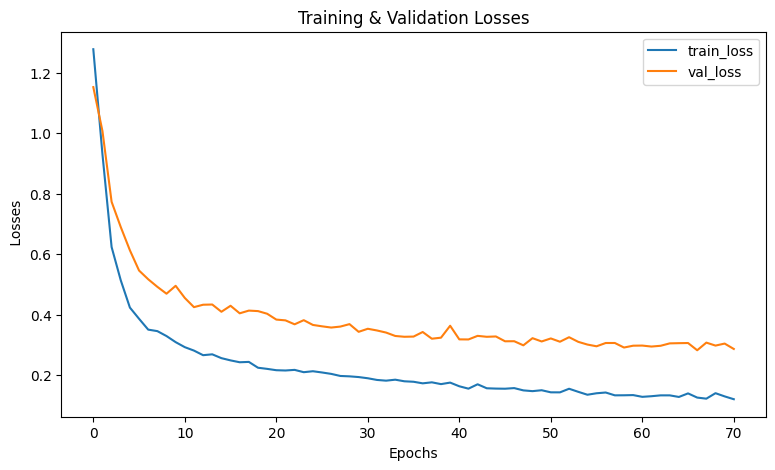

Epoch: 72 of 300
Train loss: 0.12179, Dice: 0.10864, BCE: 0.01316 | Test loss: 0.29390, Dice: 0.24066, BCE: 0.05324

Epoch: 73 of 300
Train loss: 0.11686, Dice: 0.10425, BCE: 0.01261 | Test loss: 0.29372, Dice: 0.24410, BCE: 0.04962

Epoch: 74 of 300
Train loss: 0.11253, Dice: 0.10040, BCE: 0.01213 | Test loss: 0.28286, Dice: 0.23118, BCE: 0.05168

Epoch: 75 of 300
Train loss: 0.11289, Dice: 0.10074, BCE: 0.01216 | Test loss: 0.28661, Dice: 0.23730, BCE: 0.04931

Epoch: 76 of 300
Train loss: 0.10978, Dice: 0.09800, BCE: 0.01178 | Test loss: 0.28917, Dice: 0.23611, BCE: 0.05306



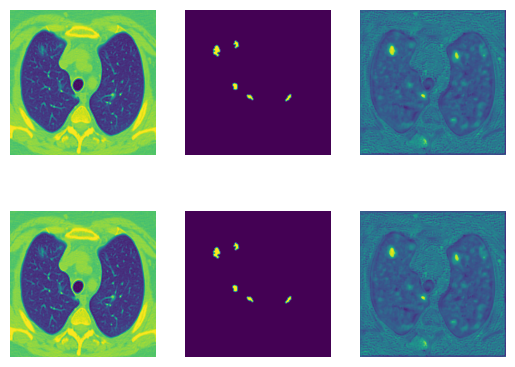

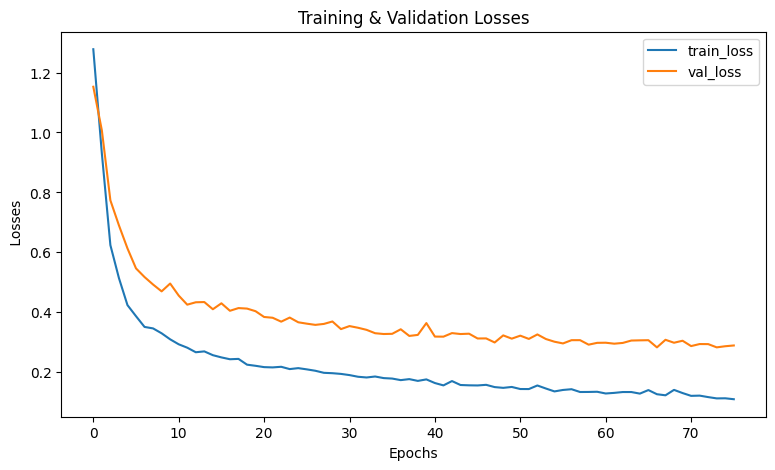

Epoch: 77 of 300
Train loss: 0.11114, Dice: 0.09927, BCE: 0.01186 | Test loss: 0.28499, Dice: 0.23150, BCE: 0.05350

Epoch: 78 of 300
Train loss: 0.11084, Dice: 0.09889, BCE: 0.01195 | Test loss: 0.28701, Dice: 0.23863, BCE: 0.04838

Epoch: 79 of 300
Train loss: 0.11856, Dice: 0.10574, BCE: 0.01281 | Test loss: 0.27357, Dice: 0.23019, BCE: 0.04338

Epoch: 80 of 300
Train loss: 0.11235, Dice: 0.10019, BCE: 0.01216 | Test loss: 0.27174, Dice: 0.22669, BCE: 0.04506

Epoch: 81 of 300
Train loss: 0.10865, Dice: 0.09706, BCE: 0.01159 | Test loss: 0.27940, Dice: 0.23018, BCE: 0.04922



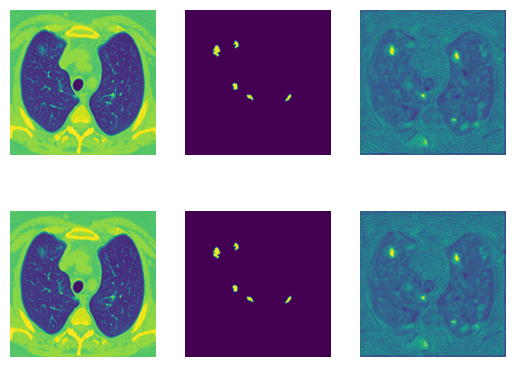

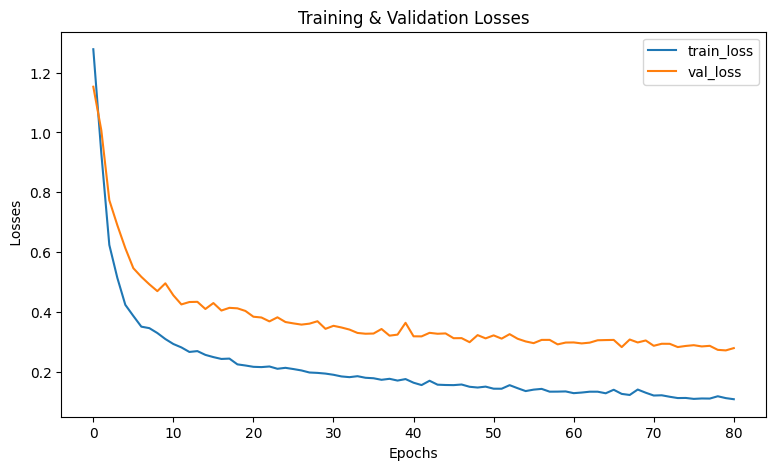

Epoch: 82 of 300
Train loss: 0.10900, Dice: 0.09748, BCE: 0.01152 | Test loss: 0.28249, Dice: 0.23067, BCE: 0.05182

Epoch: 83 of 300
Train loss: 0.11106, Dice: 0.09921, BCE: 0.01186 | Test loss: 0.27895, Dice: 0.22868, BCE: 0.05027

Epoch: 84 of 300
Train loss: 0.11160, Dice: 0.09960, BCE: 0.01200 | Test loss: 0.28469, Dice: 0.23885, BCE: 0.04584

Epoch: 85 of 300


KeyboardInterrupt: 

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Define model

# Setup loss function and optimizer
loss_fn_1 = DiceLoss()
loss_fn_2 = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 300
train_total_losses = []
val_total_losses = []

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    train_losses, test_losses = [], []
    print(f"Epoch: {epoch+1} of {epochs}")

    ### Training
    train_loss_1, train_loss_2, train_loss = 0, 0, 0

    model.train()

    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss_1 = loss_fn_1(y_pred, y)
        loss_2 = loss_fn_2(y_pred, y)
        loss = loss_1 + loss_2
        train_loss += loss.item()  # accumulate the loss per epoch
        train_loss_1 += loss_1.item()
        train_loss_2 += loss_2.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        train_losses.append(loss.item())

    # Divide total train loss by the length of the train dataloader (average loss per batch per epoch)
    train_loss /= len(train_loader)
    train_loss_1 /= len(train_loader)
    train_loss_2 /= len(train_loader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss_1, test_loss_2, test_loss = 0, 0, 0
    model.eval()

    for X, y in val_loader:
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (accumulatively)
        loss_1 = loss_fn_1(y_pred, y)
        loss_2 = loss_fn_2(y_pred, y)
        loss = loss_1 + loss_2
        test_loss += loss.item()
        test_loss_1 += loss_1.item()
        test_loss_2 += loss_2.item()

        test_losses.append(loss.item())

    # Calculations on test metrics need to happen outside the loop
    # Divide total test loss by the length of the test dataloader (per batch)
    test_loss /= len(val_loader)
    test_loss_1 /= len(val_loader)
    test_loss_2 /= len(val_loader)

    ## Print out what's happening
    print(f"Train loss: {train_loss:.5f}, Dice: {train_loss_1:.5f}, BCE: {train_loss_2:.5f} | Test loss: {test_loss:.5f}, Dice: {test_loss_1:.5f}, BCE: {test_loss_2:.5f}\n")

    train_loss = np.average(train_losses)
    train_total_losses.append(train_loss)

    val_loss = np.average(test_losses)
    val_total_losses.append(test_loss)

    if epoch % 5 == 0:
        plt.subplot(231)
        plt.imshow(X[0, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(232)
        plt.imshow(y[0, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(233)
        plt.imshow(y_pred[0, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(234)
        plt.imshow(X[0, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(235)
        plt.imshow(y[0, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(236)
        plt.imshow(y_pred[0, 0].cpu().detach().numpy())
        plt.axis('off')
        plt.show()

    if epoch % 5 == 0 and epoch != 0:
        torch.save(model.state_dict(), f"./model-{epoch}.pth")
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_total_losses, label='train_loss')
        plt.plot(val_total_losses, label='val_loss')
        plt.title("Training & Validation Losses")
        plt.ylabel(" Losses")
        plt.xlabel("Epochs")
        plt.legend()
        plt.show()


In [ ]:
torch.save(model.state_dict(), f"./model.pth")

# Inference

In [ ]:
model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        #
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

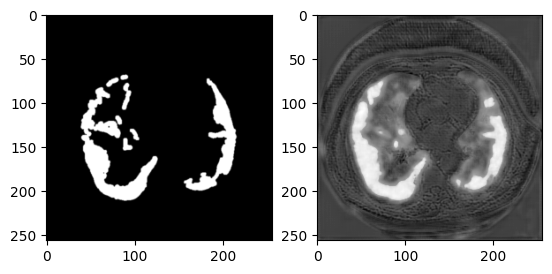

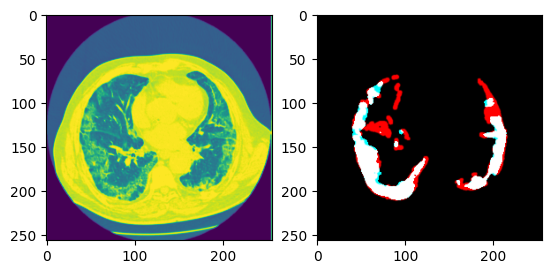

In [ ]:
y1 = y[0, 0].cpu().detach().numpy()
y2 = y_pred[0, 0].cpu().detach().numpy()

plt.subplot(121)
plt.imshow(y1, cmap='gray')

plt.subplot(122)
plt.imshow(y2, cmap='gray')
plt.show()

y_color = np.zeros((*y2.shape, 3))
y_color[..., 0] = y1
y_color[..., 1] = y2
y_color[..., 2] = y2


plt.subplot(121)
plt.imshow(X[0, 0].cpu().detach().numpy())

plt.subplot(122)
plt.imshow(y_color)

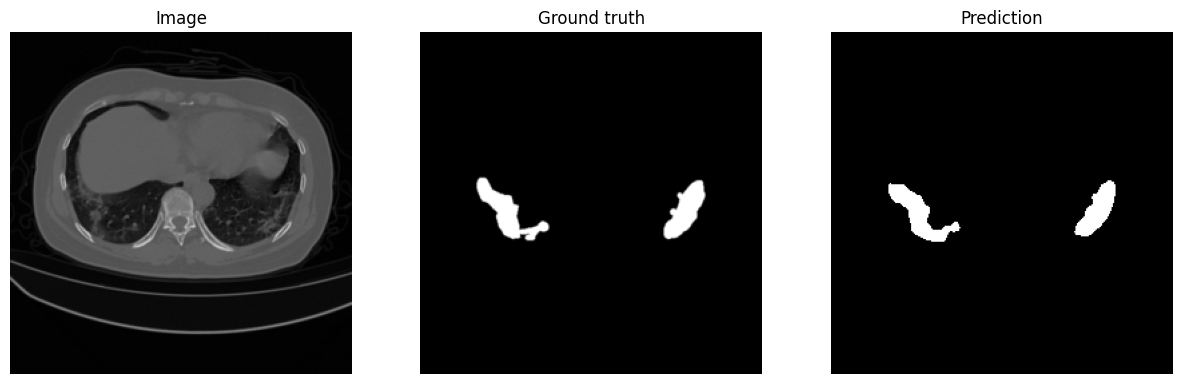

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'test_loader' is your DataLoader
batch = next(iter(test_loader))

with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))
pr_masks = (logits.squeeze(1) > 0.5).float()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(15, 5))  # Increase the width for better visualization

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Use permute for CHW to HWC conversion
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    # Convert RGB to grayscale for ground truth mask
    grayscale_gt_mask = np.mean(gt_mask.squeeze().cpu().numpy(), axis=0)
    plt.imshow(grayscale_gt_mask, cmap='gray')
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    # Convert RGB to grayscale for prediction mask
    if pr_mask.shape[0] == 3:
        grayscale_pr_mask = np.mean(pr_mask.cpu().numpy(), axis=0)
        plt.imshow(grayscale_pr_mask, cmap='gray')
    else:
        plt.imshow(pr_mask.cpu().numpy(), cmap='gray')

    plt.title("Prediction")
    plt.axis("off")
    plt.show()


In [ ]:
# Assuming 'test_loader' is your DataLoader
batch = next(iter(val_loader))

with torch.no_grad():
    model.eval()
    logits = model(batch[0].to(device))  # Assuming image is at index 0
pr_masks = (logits.squeeze(1) > 0.5).float()

# Iterate through the batches
for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    grayscale_gt_mask = np.mean(gt_mask.squeeze().cpu().numpy(), axis=0)
    plt.imshow(grayscale_gt_mask, cmap='gray')
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    if pr_mask.shape[0] == 3:
        grayscale_pr_mask = np.mean(pr_mask.cpu().numpy(), axis=0)
        plt.imshow(grayscale_pr_mask, cmap='gray')
    else:
        plt.imshow(pr_mask.cpu().numpy(), cmap='gray')

    plt.title("Prediction")
    plt.axis("off")
    plt.show()
